In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
# Load this once, to speed up load_site_inventory below
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
len(all_cities)

108

In [8]:
# Load this once, to speed up load_all_new_building_permits below
abag_permits_df = utils.load_abag_permits()

In [80]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [83]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_sites[city] = utils.load_site_inventory(city, sites_df=sites_df)
            cities_with_sites[city].relcapcty.sum()
        except Exception:
            pass

CPU times: user 7.36 s, sys: 202 ms, total: 7.56 s
Wall time: 7.71 s


In [84]:
len(cities_with_sites)

108

In [11]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city, abag_permits_df)
        except Exception:
            print(city, file=sys.stderr)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
Contra Costa County
Alameda County
Corte Madera
Marin County
Pleasant Hill
Saint Helena
Napa County
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Hillsborough
San Mateo County
Sonoma County


CPU times: user 5min 24s, sys: 9.11 s, total: 5min 33s
Wall time: 5min 45s


Solano County


In [18]:
len(cities_with_permits)

97

In [19]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [20]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [21]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [22]:
len(cities)

97

In [86]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [87]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape

CPU times: user 9.54 s, sys: 1.59 s, total: 11.1 s
Wall time: 11.9 s


/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [88]:
results_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.012,0.025,0.020,2 / 167,6 / 237,8 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41
2,Alameda,0.535,NaN,0.000,0.000,0.000,0.000,0 / 7,0 / 11,0 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.165,0.119,7 / 99,17 / 103,24 / 202
4,Fremont,0.876,0.438,0.112,0.028,0.048,0.031,4 / 141,1 / 21,5 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.083,0.083,0.083,2 / 24,3 / 36,5 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.026,0.023,0 / 9,2 / 77,2 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [91]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

CPU times: user 1min 22s, sys: 3.73 s, total: 1min 26s
Wall time: 1min 27s


In [92]:
results_geo_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.030,0.034,0.032,5 / 167,8 / 237,13 / 404
1,Albany,0.634,NaN,0.000,0.091,0.125,0.098,3 / 33,1 / 8,4 / 41
2,Alameda,0.535,NaN,0.000,0.286,0.273,0.278,2 / 7,3 / 11,5 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.272,0.173,7 / 99,28 / 103,35 / 202
4,Fremont,0.876,0.438,0.112,0.099,0.095,0.099,14 / 141,2 / 21,16 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.042,0.111,0.083,1 / 24,4 / 36,5 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [93]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/reshape

CPU times: user 1min 40s, sys: 7.16 s, total: 1min 48s
Wall time: 1min 53s


In [94]:
results_both_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.030,0.034,0.032,5 / 167,8 / 237,13 / 404
1,Albany,0.634,NaN,0.000,0.091,0.125,0.098,3 / 33,1 / 8,4 / 41
2,Alameda,0.535,NaN,0.000,0.286,0.273,0.278,2 / 7,3 / 11,5 / 18
3,Livermore,0.577,1.238,0.245,0.101,0.282,0.193,10 / 99,29 / 103,39 / 202
4,Fremont,0.876,0.438,0.112,0.099,0.095,0.099,14 / 141,2 / 21,16 / 162
...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.083,0.139,0.117,2 / 24,5 / 36,7 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


<AxesSubplot:>

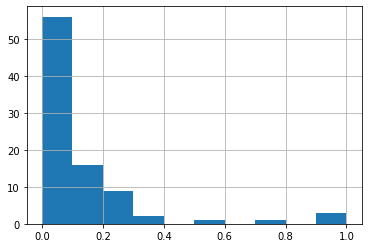

In [95]:
results_both_df['P(dev) for nonvacant sites'].hist()

In [96]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [97]:
combined_df.round(3)

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
0,Berkeley,0.348,1.255,0.041,0.012,0.025,0.020,2 / 167,6 / 237,8 / 404,0.348,1.255,0.041,0.030,0.034,0.032,5 / 167,8 / 237,13 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41,0.634,NaN,0.000,0.091,0.125,0.098,3 / 33,1 / 8,4 / 41
2,Alameda,0.535,NaN,0.000,0.000,0.000,0.000,0 / 7,0 / 11,0 / 18,0.535,NaN,0.000,0.286,0.273,0.278,2 / 7,3 / 11,5 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.165,0.119,7 / 99,17 / 103,24 / 202,0.577,1.238,0.245,0.071,0.272,0.173,7 / 99,28 / 103,35 / 202
4,Fremont,0.876,0.438,0.112,0.028,0.048,0.031,4 / 141,1 / 21,5 / 162,0.876,0.438,0.112,0.099,0.095,0.099,14 / 141,2 / 21,16 / 162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
93,Healdsburg,0.511,0.279,0.028,0.083,0.083,0.083,2 / 24,3 / 36,5 / 60,0.511,0.279,0.028,0.042,0.111,0.083,1 / 24,4 / 36,5 / 60
94,Fairfield,0.320,0.300,0.001,0.000,0.026,0.023,0 / 9,2 / 77,2 / 86,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
95,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [98]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [99]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by APN)'] - combined_df['P(dev) for nonvacant sites (by geomatching)']).abs() > 0.3
]

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
18,San Francisco,0.552246,NaN,0.266158,1.000000,1.000000,1.000000,4618 / 4618,1540 / 1540,6158 / 6158,0.552246,NaN,0.266158,0.074924,0.075974,0.075187,346 / 4618,117 / 1540,463 / 6158
48,San Bruno,0.463822,0.426667,0.128000,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6,0.463822,0.426667,0.128000,0.000000,NaN,0.000000,0 / 6,0 / 0,0 / 6
57,Colma,2.884615,2.538462,0.880000,1.000000,NaN,1.000000,1 / 1,0 / 0,1 / 1,2.884615,2.538462,0.880000,0.000000,NaN,0.000000,0 / 1,0 / 0,0 / 1
63,Portola Valley,0.585185,1.375000,0.139241,0.000000,0.105263,0.102564,0 / 2,8 / 76,8 / 78,0.585185,1.375000,0.139241,1.000000,0.118421,0.141026,2 / 2,9 / 76,11 / 78
96,Windsor,0.161681,NaN,0.025000,0.106383,0.000000,0.098039,5 / 47,0 / 4,5 / 51,0.161681,NaN,0.025000,0.531915,0.000000,0.490196,25 / 47,0 / 4,25 / 51


In [102]:
combined_df[
    combined_df['City'].isin(['Alameda', 'Antioch', 'Walnut Creek'])
]

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
2,Alameda,0.534967,NaN,0.0,0.0,0.0,0.0,0 / 7,0 / 11,0 / 18,0.534967,NaN,0.0,0.285714,0.272727,0.277778,2 / 7,3 / 11,5 / 18
20,Antioch,0.394536,NaN,0.0,0.0,0.0,0.0,0 / 6,0 / 3,0 / 9,0.394536,NaN,0.0,0.000000,0.000000,0.000000,0 / 6,0 / 3,0 / 9
27,Walnut Creek,0.992167,NaN,0.0,0.0,0.0,0.0,0 / 122,0 / 2,0 / 124,0.992167,NaN,0.0,0.024590,0.500000,0.032258,3 / 122,1 / 2,4 / 124


In [100]:
cities_with_sites['San Bruno']

,objectid,apn,locapn,genplan,zoning,gacres,locacres,allowden,allowhigh,relcapcty,...,aff_am,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry,index
38713,80847,20193380,20193380,TOD,C,2.134,2.26,60.0,60,136.0,...,NaN,"Underutilized, margi",Y,NaN,Melody Toyota Service,NaN,8.820512e-07,0.004186,"POLYGON ((-122.41072 37.62951, -122.41126 37.6...",0
38714,80848,17080150,17080150,P/QP,OS,82.069,1.50,8.0,8,39.0,...,NaN,"Underutilized, margi",NaN,NaN,Vacant,NaN,3.392484e-05,0.045180,"POLYGON ((-122.46739 37.62722, -122.46867 37.6...",1
38715,80849,17080150,17080150,P/QP,OS,82.069,4.83,24.0,24,36.0,...,NaN,"Underutilized, margi",NaN,NaN,Vacant,NaN,3.392484e-05,0.045180,"POLYGON ((-122.46739 37.62722, -122.46867 37.6...",2
38716,80850,20013120,20013120,P-D,P-D,1.435,1.44,60.0,60,86.0,...,NaN,"Underutilized, margi",Y,NaN,Airport Office Park,NaN,5.930210e-07,0.003430,"POLYGON ((-122.42325 37.63530, -122.42349 37.6...",3
38717,80851,20010720,20010720,P-D,P-D,1.472,1.54,60.0,60,92.0,...,NaN,"Underutilized, margi",Y,NaN,Airport Office Park,NaN,6.086902e-07,0.003579,"POLYGON ((-122.42341 37.63524, -122.42401 37.6...",4
38718,80852,20012160,20012160,R-O,C,6.423,7.50,20.0,20,150.0,...,NaN,"Underutilized, margi",NaN,NaN,Vacant,NaN,2.655139e-06,0.009005,"POLYGON ((-122.42789 37.62697, -122.42780 37.6...",5


<AxesSubplot:>

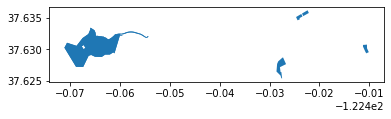

In [103]:
cities_with_sites['San Bruno'].plot()

<AxesSubplot:>

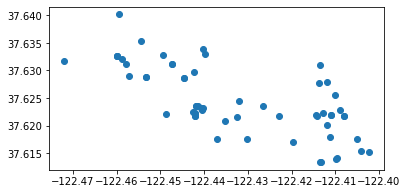

In [104]:
cities_with_permits['San Bruno'].plot()

In [235]:
import contextily as cx

def plot_city(sites, permits):
    ax = sites.plot(color='blue', edgecolor='red', figsize=(15, 15))
    permits.plot(ax=ax, color='green', markersize=3)
    
#     cx.add_basemap(ax, zoom=18, crs='EPSG:4326')
#     cx.add_basemap(ax, zoom=16, crs='EPSG:4326')
#     cx.add_basemap(
#         ax,
#         source='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png?api_key=c50d11b9-261a-4916-b968-fe8854621c78',
#         zoom=15,
#         crs='EPSG:4326'
#     )
    cx.add_basemap(
        ax,
        source=cx.providers.Stamen.TonerLite,
#         zoom=15,
        crs='EPSG:4326',
    )

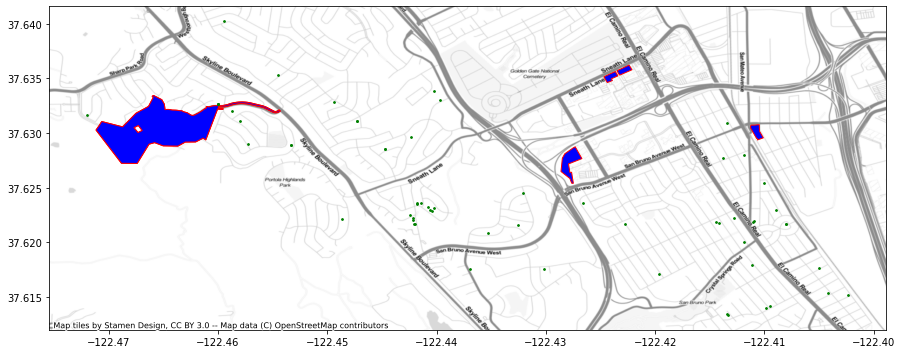

In [236]:
plot_city(cities_with_sites['San Bruno'], cities_with_permits['San Bruno'])

In [227]:
sites = cities_with_sites['Windsor']
permits = cities_with_permits['Windsor']

In [242]:
sites.columns

Index(['objectid', 'apn', 'locapn', 'genplan', 'zoning', 'gacres', 'locacres',
       'allowden', 'allowlow', 'allowhigh', 'relcapcty', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_m', 'num_am', 'infcapcty', 'siteconst',
       'sitetype', 'pdaparcel', 'bundled', 'existuse', 'localnote',
       'Shape__Are', 'Shape__Len', 'geometry', 'index'],
      dtype='object')

In [246]:
sites[['apn', 'locapn', 'relcapcty', 'gacres', 'zoning', 'locacres', 'allowden']]

,apn,locapn,relcapcty,gacres,zoning,locacres,allowden
40150,164530005,164530005,NaN,0.014,NaN,0.0,NaN
40161,164520012,164520012,NaN,0.027,NaN,0.0,NaN
40162,164520013,164520013,NaN,0.027,NaN,0.0,NaN
40163,164520014,164520014,NaN,0.028,NaN,0.0,NaN
40164,164520015,164520015,NaN,0.025,NaN,0.0,NaN
40165,164530001,164530001,NaN,0.015,NaN,0.0,NaN
40166,164530002,164530002,NaN,0.016,NaN,0.0,NaN
40167,164530003,164530003,NaN,0.017,NaN,0.0,NaN
40168,164530004,164530004,NaN,0.015,NaN,0.0,NaN
40169,164530006,164530006,NaN,0.021,NaN,0.0,NaN


In [228]:
permits[
    permits.apn.isin(
        sites.apn
    )
][['permyear', 'address', 'totalunit', 'apn']]

,permyear,address,totalunit,apn
22,2015,126 Johnson St.,1,164530004.0
23,2015,128 Johnson St.,1,164530005.0
24,2015,124 Johnson St.,1,164530003.0
25,2015,122 Johnson St.,1,164530002.0
26,2015,120 Johnson St.,1,164530001.0


In [234]:
permits[['permyear', 'address', 'totalunit']]

,permyear,address,totalunit
0,2017,222 Johnson St,1
1,2017,6087 Old Redwood Hwy,36
2,2017,112 Carey Ct,1
3,2017,9757A Dawn Way,1
4,2016,10341 Herb Rd,1
...,...,...,...
68,2019,915 Starr Creek Ct,1
69,2019,8770 Starr Rd,1
70,2019,411 Harper Ct,1
71,2019,9821 Dawn Way,1


In [229]:
sites.columns

Index(['objectid', 'apn', 'locapn', 'genplan', 'zoning', 'gacres', 'locacres',
       'allowden', 'allowlow', 'allowhigh', 'relcapcty', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_m', 'num_am', 'infcapcty', 'siteconst',
       'sitetype', 'pdaparcel', 'bundled', 'existuse', 'localnote',
       'Shape__Are', 'Shape__Len', 'geometry', 'index'],
      dtype='object')

In [230]:
sites[
    sites['apn'] == 17080150.0
][['apn', 'locapn', 'relcapcty', 'gacres', 'locacres', 'localnote', 'index', 'existuse', 'sitetype', 'zoning']]

,apn,locapn,relcapcty,gacres,locacres,localnote,index,existuse,sitetype,zoning


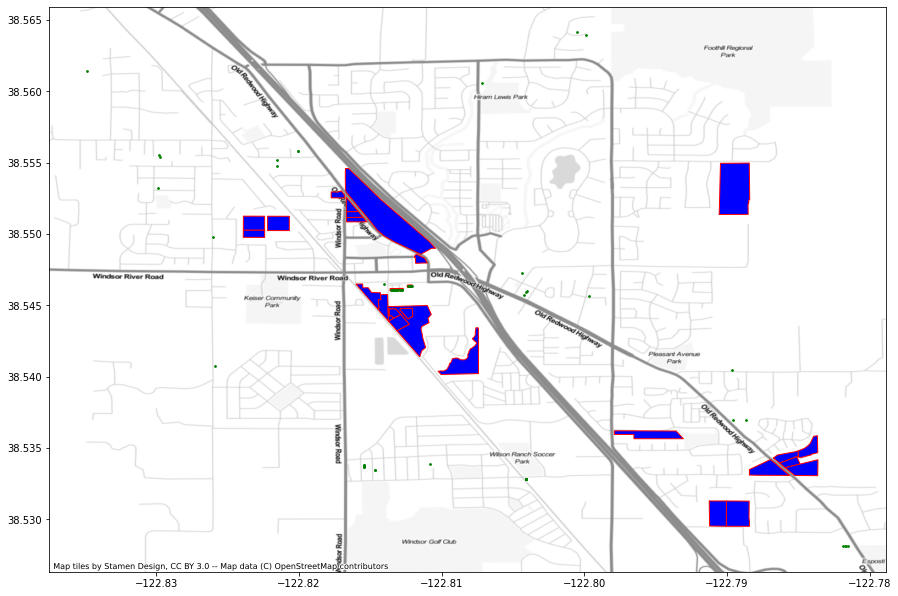

In [237]:
plot_city(cities_with_sites['Windsor'], cities_with_permits['Windsor'])

In [137]:
cities_with_permits['San Bruno'].columns

Index(['objectid', 'joinid', 'permyear', 'county', 'jurisdictn', 'apn',
       'address', 'zip', 'projname', 'hcategory', 'vlowdr', 'vlowndr',
       'vlowtot', 'lowdr', 'lowndr', 'lowtot', 'moddr', 'modndr', 'modtot',
       'amodtot', 'totalunit', 'tenure', 'mapped', 'mapnotes', 'pda',
       'pdacycle', 'pdajoinid', 'tpa', 'tpacycle', 'hsngsite', 'rhnacycle',
       'notes', 'ObjectId2', 'OBJECTID', 'geometry', 'Prior APN+',
       'Local Jurisdiction Tracking ID+', 'Building Permits Date Issued',
       'How many of the units were Extremely Low Income?+',
       'Was Project APPROVED using GC 65913.4(b)? (SB 35 Streamlining) Y/N',
       'Infill Units? Y/N+', 'Deed Restriction Type (see instructions)',
       'For units affordable without financial assistance or deed restrictions, explain how the locality determined the units were affordable (see instructions)',
       'Term of Affordability or Deed Restriction (years) (if affordable in perpetuity enter 1000)+',
       'Number of D

In [45]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:k
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.845360824742268
P(dev) for vacant sites 0.7938144329896907
P(dev) for inventory 0.8969072164948454


In [46]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.27835051546391754
P(dev) for vacant sites 0.25773195876288657
P(dev) for inventory 0.17525773195876287


# "Ground truth" data

In [667]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [672]:

permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [673]:
print(permits.columns)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [685]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['county', 'num_vl', 'rhnayrs', 'rhnacyc', 'infcapcty', 'allowlow', 'jurisdict', 'num_m', 'num_am', 'num_l']
DF shape (57, 25)
Total units permitted: 532
Total realistic capacity in inventory: 257.5
Number of inventory sites developed: 9
Number of units permitted on inventory sites: 34
Total realistic capacity of inventory sites: 38.0
Units permitted on inventory sites: 34
Total units permitted: 532
Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


KeyError: 'Block'

In [684]:
ground_truth_results_df

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
0,Los Altos,2.066019,-0.444444,0.06391,0.088235,0.26087,0.157895
